# Quant Finance - Trabajo Final

### Importo los modulos que voy a utilizar

In [67]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from scipy.optimize import curve_fit
import sys
sys.path.append("..")
from Script_aux import*
%matplotlib inline

#### Importo las yields diarias de los treasury bonds y armo la tabla con las maturities para det. fecha.
Tambien ordeno el dataframe para poder trabajar de manera mas simple mas adelante

In [68]:
filedata=pd.read_excel(r"T Bills yields 2020.xlsx","2017")
data_ts=filedata.loc[filedata["Date"]=="2017-09-15"].T
data_ts.reset_index(inplace=True)
data_ts=data_ts.drop([0])
data_ts.rename(columns={int(177):"2017-09-15","index":"Maturity"},inplace=True)
filedata.drop(columns=["2 Mo"],axis=1,inplace=True)
data_ts.drop([2],axis=0,inplace=True)
data_ts.reset_index(drop=True,inplace=True)
data_ts=data_ts[["Maturity","2017-09-15"]]
filedata.set_index("Date",inplace=True)

#Anualizo las maturities para trabajar

t_mat=[30/360,90/360,180/360,1,2,3,5,7,10,20,30]

### Defino las características de la 3-Year Treasury Note con la que voy a trabajar en gran parte del trabajo

In [69]:
#Defino el Indenture de la T-Note a 3 años a valuar

#Emision
tb_issue=dt.date(2017,9,15)
#Vencimiento
tb_mat=dt.date(2020,9,15)
#Tasa del cupon
cupon_rate=1.375
#Maturity
maturity_tb=3
#Las fechas de pago son todos los 15 de marzo y 15 de septiembre;
#Creo dos listas con la info de la fecha del pago del principal y de los cupones
principal=[dt.date(2020,9,15)]
cupon=[dt.date(2018,3,15), #1er pago
       dt.date(2018,9,15), #2do pago
       dt.date(2019,3,15), #3er pago
       dt.date(2019,9,15), #4to pago
       dt.date(2020,3,15), #5to pago
       dt.date(2020,9,15), #6to pago
       ]

### Comienzo haciendo la primera valuación de la 3-Year Treasury Note con una tasa de descuento constante

In [70]:
#Primera valuacion

bono_caso1=bon_precio_df(3,100,1.375,2)
print(bono_caso1)

0    99.63465
dtype: float64


### Grafico la relación inversa que existe entre el precio de un bono y la tasa de descuento

Text(0, 0.5, 'Precio')

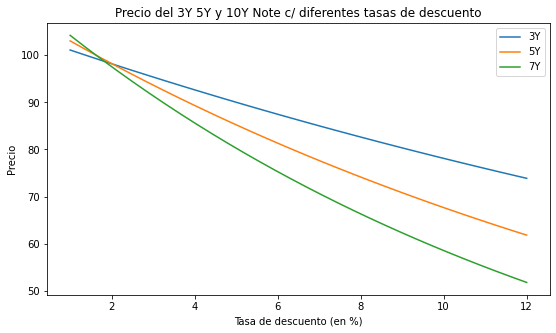

In [71]:
#Muestro como varia el precio del bono ante la variacion de la tasa de descuento

rates=np.linspace(1,12,num=30)
bon3=[bon_precio(3,100,1.375,2,rate) for rate in rates]
bon3_df=pd.DataFrame(data=bon3,index=rates)
bon5=[bon_precio(5,100,1.625,2,rate) for rate in rates]
bon5_df=pd.DataFrame(data=bon5,index=rates)
bon10=[bon_precio(7,100,1.625,2,rate) for rate in rates]
bon10_df=pd.DataFrame(data=bon10,index=rates)
bonos=pd.merge(bon3_df,bon5_df,left_index=True,right_index=True)
bonos=pd.merge(bonos,bon10_df,left_index=True,right_index=True)
bonos.set_index(rates,inplace=True)
ax=bonos.plot(figsize=(9,5),title="Precio del 3Y 5Y y 10Y Note c/ diferentes tasas de descuento",legend=["3Y","5Y","10Y"])
ax.legend(["3Y","5Y","7Y"])
ax.set_xlabel("Tasa de descuento (en %)")
ax.set_ylabel("Precio")

### Grafico la Term Structure del Tesoro de los EE.UU. para diferentes fechas

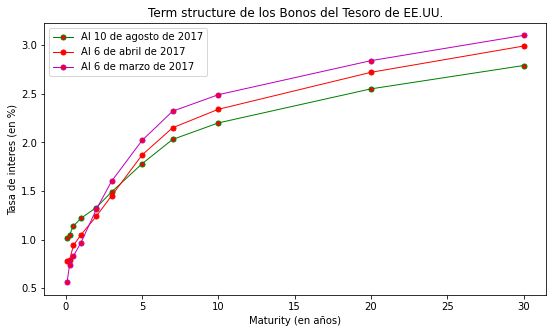

In [72]:
#Selecciono algunas fechas para comparar las yields del Tesoro de EE.UU. en los distintos dias

fecha_1=dt.date(2017, 8, 10)
fecha_2=dt.date(2017,4,6)
fecha_3=dt.date(2017,3,6)

#Grafico

def grafico_ts_base():
    plt.figure(figsize=(9,5))
    #plt.plot(t_mat,filedata.loc["2017-09-15"],marker='.',mfc="red",markersize=10, color='b', linewidth=1,label="Al 6 de noviembre de 2020")
    plt.plot(t_mat,filedata.loc[fecha_1],marker='.',mfc="red",markersize=10, color='g', linewidth=1,label="Al 10 de agosto de 2017")
    plt.plot(t_mat,filedata.loc[fecha_2],marker='.',mfc="red",markersize=10, color='r', linewidth=1,label="Al 6 de abril de 2017")
    plt.plot(t_mat,filedata.loc[fecha_3],marker='.',mfc="red",markersize=10, color='m', linewidth=1,label="Al 6 de marzo de 2017")
    plt.title("Term structure de los Bonos del Tesoro de EE.UU.")
    plt.xlabel("Maturity (en años)")
    plt.ylabel("Tasa de interes (en %)")
    plt.legend(loc="upper left")
    
grafico_ts_base()

### Utilizo varios metodos de interpolación y optimización de la Term Structure

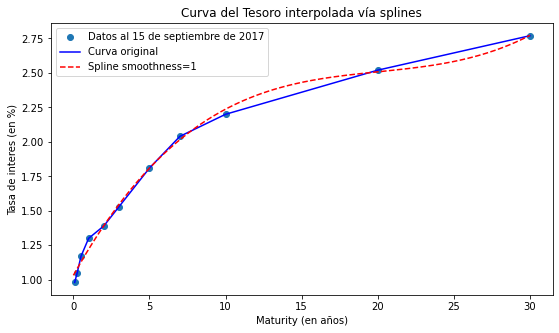

In [73]:
#Interpolación vía splines

Interpl(t_mat,data_ts["2017-09-15"])

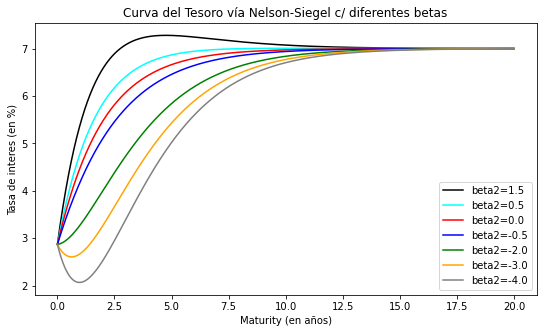

[3.065851813285462, -2.0497006780091653, -0.8424777933679357, 3.229732563151932]


C:\Users\santi\Script_aux.py:77: RuntimeWarning: divide by zero encountered in true_divide
  return b0 + (b1 + b2) * t1/T * (1 - np.exp(-T/t1)) - b2 * np.exp(-T/t1)
C:\Users\santi\Script_aux.py:77: RuntimeWarning: invalid value encountered in multiply
  return b0 + (b1 + b2) * t1/T * (1 - np.exp(-T/t1)) - b2 * np.exp(-T/t1)


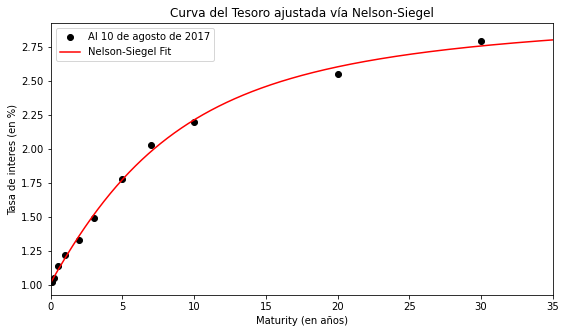

In [74]:
#Nelson-Siegel

plotNelsonSiegel()
fitNelsonSiegel(t_mat,filedata.loc[fecha_1])

### Para hacer un segunda valuación del bono, utilizo los datos de la Yield Curve del Tesoro vigentes el 9 de septiembre de 2017 

In [75]:
#Expreso los cupones del bono en fraccion anual con respecto a la fecha de valuación, la cual será al momento de la emisión

cupon_frac=pagos_frac(cupon,tb_issue,360)
cupon_frac

1    0.502778
2    1.013889
3    1.516667
4    2.027778
5    2.533333
6    3.044444
dtype: float64

In [76]:
#Estructura de pagos del 3Y Note es

pagos=cashflow_bono(3,100,cupon_rate,2)
pagos

1      0.6875
2      0.6875
3      0.6875
4      0.6875
5      0.6875
6    100.6875
dtype: float64

In [77]:
#Lista con los pagos de los cupones calculados; segun el prospecto del bono...

df_pago_cup=pd.DataFrame(data=pagos,columns=["pagos"])
df_pago_frac=pd.DataFrame(data=cupon_frac,columns=["maturities"])

#Uno el DF con las fracciones de anio y los pagos
cashflow=pd.merge(df_pago_frac,df_pago_cup,left_index=True,right_index=True)

In [78]:
#Antes de seguir adelante, interpolo los datos observados de las Yield Curve del Tesoro
#el dia de la valuacion: 15 de septiembre de 2017

df_t_mat=pd.DataFrame(t_mat)
df_t_mat.rename(columns={0:"maturities"},inplace=True)
temp=pd.merge(df_t_mat,data_ts,left_index=True,right_index=True)
df_pago_frac.reset_index(drop=True,inplace=True)
temp=temp[["maturities","2017-09-15"]]
df_data_ts=pd.merge(temp,df_pago_frac,"outer")
df_data_ts.sort_values(by=["maturities"],inplace=True)
df_data_ts.reset_index(drop=True,inplace=True)
#Convierto de objeto a float los valores de la columna de tasas para
#poderlos interpolar
df_data_ts["2017-09-15"]=df_data_ts["2017-09-15"].astype(float)
#Reemplazo los NaN con el valor interpolado
df_data_ts=df_data_ts.interpolate(method="polynomial",order=2)
df_data_ts

,maturities,2017-09-15
0,0.083333,0.980000
1,0.250000,1.050000
2,0.500000,1.170000
3,0.502778,1.251392
4,1.000000,1.300000
5,1.013889,1.336414
6,1.516667,1.362562
7,2.000000,1.390000
8,2.027778,1.420655
9,2.533333,1.458792


In [79]:
#Ahora si, calculo el precio de la 3Y Note

cashflow_descontado=pd.merge(cashflow,df_data_ts,"inner")
cashflow_descontado.rename(columns={"2017-09-15":"tasa_zcb"},inplace=True)
cashflow_descontado["VPN"]=descuento(cashflow_descontado["pagos"],cashflow_descontado["tasa_zcb"],strip=1).multiply(cashflow_descontado["pagos"],axis="index")
cashflow_descontado_sum=sum(cashflow_descontado.VPN)
print("El precio de la T Note para 3 anios es:"+str(round(cashflow_descontado_sum,2)))

El precio de la T Note para 3 anios es:102.46


### Grafico la Term Structure del Tesoro a traves de los ultimos 5 años 

X (1465, 11)
Y (1465, 11)
Z (1465, 11)


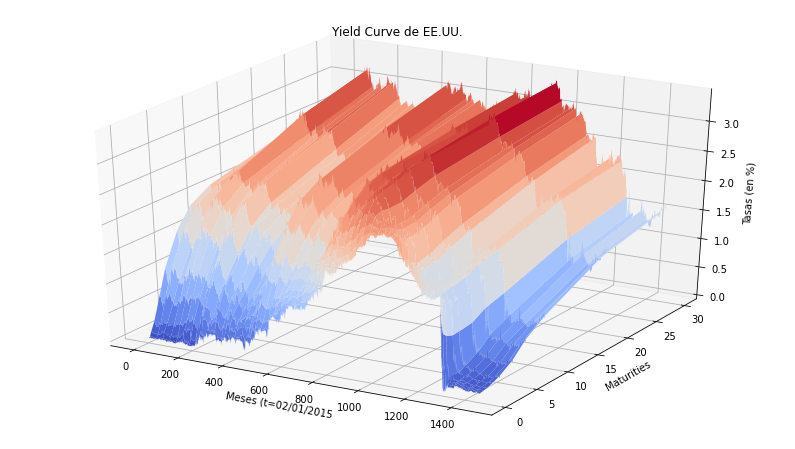

In [80]:
#Hago el grafico en 3D de la Yield Curve

grafdata_15=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\T Bills yields 2020.xlsx","2015")
grafdata_16=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\T Bills yields 2020.xlsx","2016")
grafdata_17=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\T Bills yields 2020.xlsx","2017")
grafdata_18=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\T Bills yields 2020.xlsx","2018")
grafdata_19=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\T Bills yields 2020.xlsx","2019")
grafdata_20=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\T Bills yields 2020.xlsx","2020")
grafdata=pd.concat([grafdata_15,grafdata_16,grafdata_17,grafdata_18,grafdata_19,grafdata_20])
grafdata.drop("2 Mo",axis=1,inplace=True)

t_vec=np.linspace(0,1465,1465)
graf_t_mat=[30/360,90/360,180/360,1,2,3,5,7,10,20,30] #Eje y

X,Y=np.meshgrid(t_vec,graf_t_mat)
Z=np.array(grafdata[['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr', '10 Yr', '20 Yr', '30 Yr']])
X=X.T
Y=Y.T

#Mecanismo de control
print('X', np.shape(X))
print('Y', np.shape(Y))
print('Z', np.shape(Z))

#Grafico
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm')#, edgecolor='none')#rstride=1, cstride=1,
ax.set_title('Yield Curve de EE.UU.');
ax.set_xlabel('Meses (t=02/01/2015')
ax.set_ylabel('Maturities')
ax.set_zlabel('Tasas (en %)')
plt.show()

### Calculo el modelo CIR utilizando la 3-month Treasury Bill descargada de la Reserva Federal

### Primero defino los parametros del modelo

In [81]:
#Numero de anios a simular
n_years=5
#Numero de escenarios
n_scenarios=500
#Velocidad de ajuste de la tasa
a=0.2
#Promedio de largo plazo
b=0.02
#Volatilidad anual calculada en base al promedio de los ultimos 10 años
sigma=0.0076
#Valor inicial de la tasa; 3 month rate de EEUU
tbill=pd.read_excel(r"C:\Users\santi\OneDrive\Documentos\UCEMA\Quant Finance\TP Final\Datos\3-Month Treasury Bill Secondary Market Rate.xls","Hoja1")
tbill.set_index("Date",inplace=True)
tbill_t0=data_ts.iloc[0][1]
#Lo convierto a un array para evitar un ValueError en la formula cerrada del CIR
r_0=tbill_t0
#Plazo de maturities que voy a usar para construir las ZCB Curve
maturities=[30/360,60/360,90/360,180/360,1,2,3,4,5,6,7,8,9,10,15,20,30]

#### Calculo el modelo

In [82]:
#Calculo el modelo de tasa CIR

cir_tasa,cir_zcb=cir_model(n_years,n_scenarios,a,b,sigma,r_0=r_0/100)

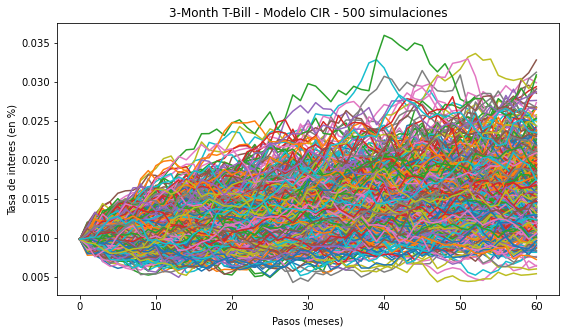

In [83]:
#Grafico las 3 M Treasury Rate simuladas

cir_tasa.plot(figsize=(9,5))
plt.title("3-Month T-Bill - Modelo CIR - "+str(n_scenarios)+" simulaciones")
plt.xlabel("Pasos (meses)")
plt.ylabel("Tasa de interes (en %)")
lg=plt.legend().remove()
plt.show()

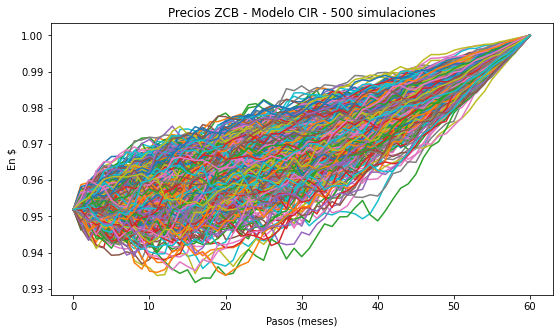

In [84]:
#Grafico los ZCB obtenidos a partir del CIR

cir_zcb.plot(figsize=(9,5))
plt.title("Precios ZCB - Modelo CIR - "+str(n_scenarios)+" simulaciones")
plt.xlabel("Pasos (meses)")
plt.ylabel("En $")
lg=plt.legend().remove()
plt.show()

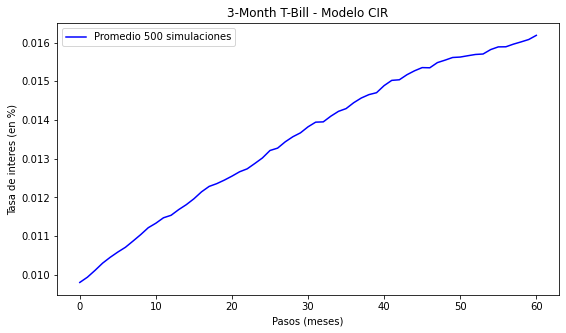

In [85]:
#Grafico la MEDIA de las n-simulaciones

#Calculo el promedio de las n-simulaciones

cir_tasa_medias=cir_tasa.transpose().mean()

#Grafico

plt.figure(figsize=(9,5))
plt.plot(cir_tasa_medias.index,cir_tasa_medias,color="b",label="Promedio "+str(n_scenarios)+" simulaciones")
plt.title("3-Month T-Bill - Modelo CIR")
plt.xlabel("Pasos (meses)")
plt.ylabel("Tasa de interes (en %)")
leg=plt.legend("Promedio "+str(n_scenarios)+" simulaciones")
plt.legend(loc="upper left")
#plt.text(-5,-1.2,"Fuente: FRED y estimaciones propias")
plt.show()

### Genero las curvas de ZCB a partir de las simulaciones del modelo CIR 

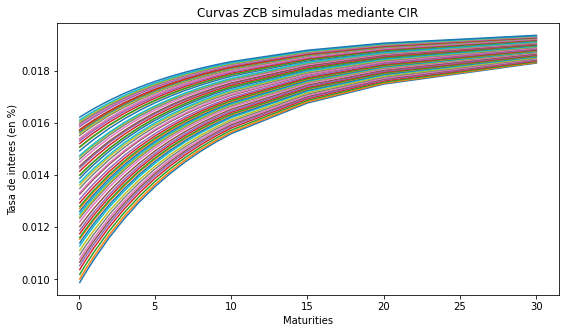

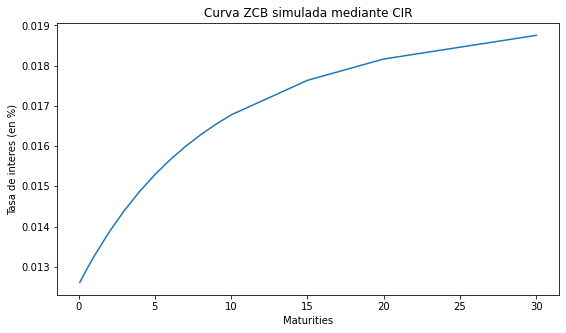

In [86]:
#Genero las ZCB Curves con las simulaciones generadas del modelo CIR
cir_zcb_ts=curva_zcb(maturities,cir_tasa_medias,sigma,a,b)

#Grafico las curvas ZCB generadas
plt.figure(figsize=(9,5))
plt.plot(maturities,cir_zcb_ts.T)
plt.title("Curvas ZCB simuladas mediante CIR")
plt.xlabel("Maturities")
plt.ylabel("Tasa de interes (en %)")
plt.show()

#Grafico una ZCB Curves en particular
plt.figure(figsize=(9,5))
plt.plot(maturities,cir_zcb_ts.loc[20].T)
plt.title("Curva ZCB simulada mediante CIR")
plt.xlabel("Maturities")
plt.ylabel("Tasa de interes (en %)")
plt.show()

### Valuo la 3Y Note al momento de su emision descontándolo con la Term Structure generada a partir de los ZCB 

In [87]:
#Ahora bien, podria usar las diferentes Zero Yields o Term Structure que genere con el modelo CIR y valuar el mismo bono y ver como cambia la valuacion segun la tasa
#Entonces vuelvo a usar el DataFrame "cashflow"

cashflow
df_pago_frac
df_temp_output=[]

for i in range(0,len(cir_zcb_ts)):
    df_temp=pd.DataFrame(data=maturities)
    df_temp.rename(columns={0:"maturities"},inplace=True)
    df_temp["tasa_zcb"]=cir_zcb_ts.loc[i]*100
    df_temp=pd.merge(df_temp,df_pago_frac,"outer")
    df_temp.sort_values(by=["maturities"],inplace=True)
    df_temp.reset_index(drop=True,inplace=True)
    df_temp["tasa_zcb"]=df_temp["tasa_zcb"].astype(float)
    #Interpolo las tasas con los pagos de la 3Y Note
    df_temp=df_temp.interpolate(method="polynomial",order=2)
    
    df_temp_2=pd.merge(cashflow,df_temp,"inner")
    df_temp_2["VPN"]=descuento(df_temp_2["pagos"],df_temp_2["tasa_zcb"],strip=1).multiply(df_temp_2["pagos"],axis="index")
    df_temp_2_sum=sum(df_temp_2.VPN)
    df_temp_output.append(df_temp_2_sum)
    
#Con esta interacion obtengo los distintos precios del 3Y Note que podria obtener segun el valor de la TS    
df_output=pd.Series(data=df_temp_output,index=range(0,len(cir_zcb_ts)))
print(round(df_output.loc[0],2))

102.83


#### Para cada momento del tiempo evaluo el precio de la 3Y Note con la TS correspondiente en cada momento del timepo;para ello calculo la fraccion de tiempo c/ a la maturity e interpolo la TS

In [88]:
#Armo una lista con la fecha de los cupones expresados en fraccion de año con respecto al momento
#de la valuacion es decir la fecha de emision del titulo

date_dyn=[dt.date(2017,9,15),dt.date(2017,10,15),dt.date(2017,11,15),dt.date(2017,12,15),dt.date(2018,1,15),dt.date(2018,2,15),
          dt.date(2018,3,15),dt.date(2018,4,15),dt.date(2018,5,15),dt.date(2018,6,15),dt.date(2018,7,15),
          dt.date(2018,8,15),dt.date(2018,9,15),dt.date(2018,10,15),dt.date(2018,11,15),dt.date(2018,12,15),
          dt.date(2019,1,15),dt.date(2019,2,15),dt.date(2019,3,15),dt.date(2019,4,15),dt.date(2019,5,15),
          dt.date(2019,6,15),dt.date(2019,7,15),dt.date(2019,8,15),dt.date(2019,9,15),dt.date(2019,10,15),
          dt.date(2019,11,15),dt.date(2019,12,15),dt.date(2020,1,15),dt.date(2020,2,15),dt.date(2020,3,15),
          dt.date(2020,4,15),dt.date(2020,5,15),dt.date(2020,6,15),dt.date(2020,7,15),dt.date(2020,8,15),
          dt.date(2020,9,15)]

In [89]:
#Voy a necesitar estos objetos

cashflow
df_pago_frac
temp_output_dyn=[]

#Creo un loop para iterar sobre el valor del bono en cada momento de su vida

for i in range(0,(maturity_tb*12)):
    cupon_frac_dyn=pagos_frac(cupon,date_dyn[i])
    df_pago_frac_dyn=pd.DataFrame(data=cupon_frac_dyn,columns=["maturities"])
    cashflow_dyn=pd.merge(df_pago_frac_dyn,df_pago_cup,left_index=True,right_index=True)
    cashflow_dyn["maturities"].replace({float(0):np.nan},inplace=True)      
    
    df_temp=pd.DataFrame(data=maturities)
    df_temp.rename(columns={0:"maturities"},inplace=True)
    df_temp["tasa_zcb"]=cir_zcb_ts.loc[i]*100
    df_temp=pd.merge(df_temp,df_pago_frac_dyn,"outer")
    df_temp.sort_values(by=["maturities"],inplace=True)
    df_temp.reset_index(drop=True,inplace=True)
    df_temp["tasa_zcb"]=df_temp["tasa_zcb"].astype(float)
    #Interpolo las tasas con los pagos de la 3Y Note
    df_temp=df_temp.interpolate(method="polynomial",order=2)

    
    df_temp_2=pd.merge(cashflow_dyn,df_temp,"inner")
    df_temp_2["VPN"]=descuento(df_temp_2["pagos"],df_temp_2["tasa_zcb"],strip=1).multiply(df_temp_2["pagos"],axis="index")
    df_temp_2.fillna(0,inplace=True)
    df_temp_2_sum=sum(df_temp_2.VPN)
    temp_output_dyn.append(df_temp_2_sum)
temp_output_dyn[-1]=100.0

#Con esta interacion obtengo los distintos precios del 3Y Note que podria obtener segun el valor de la TS    
df_output_dyn=pd.Series(data=temp_output_dyn,index=range(0,(maturity_tb*12)))
df_output_dyn

0     102.834317
1     102.890401
2     102.876173
3     102.861047
4     102.848877
5     102.157715
6     102.147847
7     102.138683
8     102.125416
9     102.110973
10    102.101659
11    102.090392
12    101.405626
13    101.456020
14    101.444854
15    101.431903
16    101.416286
17    100.724982
18    100.718774
19    100.713946
20    100.705031
21    100.695241
22    100.688949
23    100.676999
24     99.985968
25    100.014605
26    100.008924
27     99.993805
28     99.979989
29     99.292498
30     99.278126
31     99.284630
32     99.283911
33     99.269889
34     99.265388
35    100.000000
dtype: float64

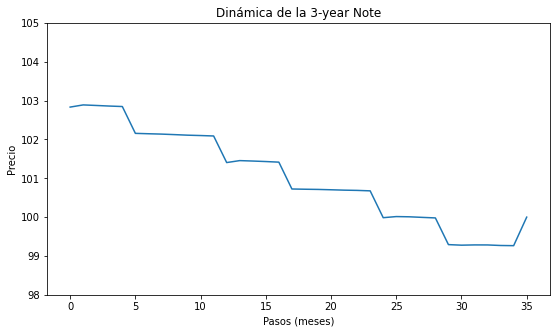

In [90]:
#Grafico

plt.figure(figsize=(9,5))
plt.plot(df_output_dyn.index,df_output_dyn)
plt.title("Dinámica de la 3-year Note")
plt.xlabel("Pasos (meses)")
plt.ylabel("Precio")
plt.ylim(98,105)
plt.show()

## ¿Cómo afecta la tasa de interés al precio de un bono? 

In [91]:
#Genero una serie de precios ficticios para ver la relacion teorica
pr_bonos=np.linspace(1,120,num=120)

In [92]:
#Cupon 3%
pr_bonos_ytm_3=np.empty_like(pr_bonos)
for t in range(0,len(pr_bonos)):
    temp_ytm=bon_ytm(pr_bonos[t],5,3,1)
    pr_bonos_ytm_3[t]=temp_ytm
df_pr_bonos_ytm_3=pd.DataFrame(data=pr_bonos_ytm_3)
    
#Cupon 5%
pr_bonos_ytm_5=np.empty_like(pr_bonos)
for t in range(0,len(pr_bonos)):
    temp_ytm=bon_ytm(pr_bonos[t],5,5,1)
    pr_bonos_ytm_5[t]=temp_ytm    
df_pr_bonos_ytm_5=pd.DataFrame(data=pr_bonos_ytm_5)

#Cupon 5% y MD 3
pr_bonos_ytm_53=np.empty_like(pr_bonos)
for t in range(0,len(pr_bonos)):
    temp_ytm=bon_ytm(pr_bonos[t],3,5,1)
    pr_bonos_ytm_53[t]=temp_ytm    
df_pr_bonos_ytm_53=pd.DataFrame(data=pr_bonos_ytm_53)
    
#Cupon 7% y MD 10
pr_bonos_ytm_7=np.empty_like(pr_bonos)
for t in range(0,len(pr_bonos)):
    temp_ytm=bon_ytm(pr_bonos[t],10,5,1)
    pr_bonos_ytm_7[t]=temp_ytm    
df_pr_bonos_ytm_7=pd.DataFrame(data=pr_bonos_ytm_7)
pr_bonos=pd.DataFrame(data=pr_bonos)

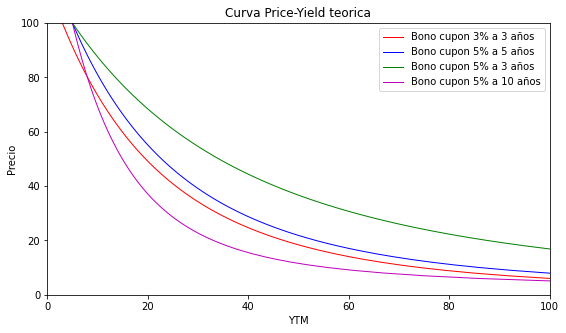

In [93]:
#Grafico la Curva Price-Yield
plt.figure(figsize=(9,5))
plt.plot(df_pr_bonos_ytm_3*100,pr_bonos, color='r', linewidth=1,label="Bono cupon 3% a 3 años")
plt.plot(df_pr_bonos_ytm_5*100,pr_bonos, color='b', linewidth=1,label="Bono cupon 5% a 5 años")
plt.plot(df_pr_bonos_ytm_53*100,pr_bonos, color='g', linewidth=1,label="Bono cupon 5% a 3 años")
plt.plot(df_pr_bonos_ytm_7*100,pr_bonos, color='m', linewidth=1,label="Bono cupon 5% a 10 años")
plt.title("Curva Price-Yield teorica")
plt.xlabel("YTM")
plt.ylabel("Precio")
plt.legend(loc="upper right")
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

### Precios de bonos y tasa de mercado

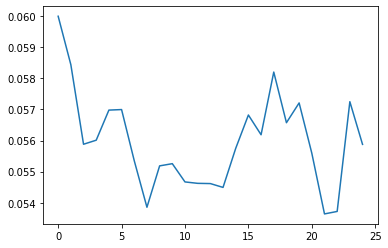

In [94]:
#Genero tasas anuales con el modelo CIR
cir_tasas_anuales,cir_zcb_anuales=cir_model(2,100,0.8,0.048,0.05,r_0=0.06)
cir_tasas_anuales_avg=cir_tasas_anuales.transpose().mean()
cir_tasas_anuales_avg.transpose().plot()
bon_maturities=range(1,20)

In [95]:
#Bono Cupon 5%
bon_5cup=[]
for i in range(1,20):
    temp=bon_precio(i,100,5,2,cir_tasas_anuales_avg.loc[i]*100)
    bon_5cup.append(temp)
    
df_bon_5cup=pd.DataFrame(data=bon_5cup,index=bon_maturities)


#Bono Cupon 3%
bon_3cup=[]
for i in range(1,20):
    temp=bon_precio(i,100,3,2,cir_tasas_anuales_avg.loc[i]*100)
    bon_3cup.append(temp)
    
df_bon_3cup=pd.DataFrame(data=bon_3cup,index=bon_maturities)


#Bono Cupon 7%
bon_7cup=[]
for i in range(1,20):
    temp=bon_precio(i,100,7,2,cir_tasas_anuales_avg.loc[i]*100)
    bon_7cup.append(temp)
    
df_bon_7cup=pd.DataFrame(data=bon_7cup,index=bon_maturities)

<ipython-input-96-04a80e41bbe2>:16: MatplotlibDeprecationWarning: Unrecognized location 'upper middle'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax1.legend(loc="upper middle")


<Figure size 648x360 with 0 Axes>

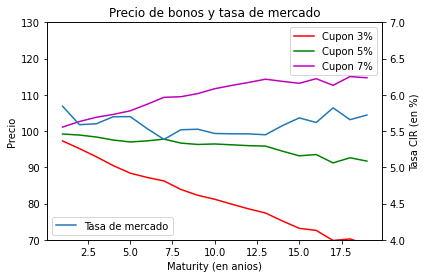

In [96]:
#Grafico los bonos y la tasa

plt.figure(figsize=(9,5))
fig,ax1=plt.subplots()
ax2=ax1.twinx()
curva1=ax1.plot(range(1,20),df_bon_3cup,color="r",label="Cupon 3%")
curva2=ax1.plot(range(1,20),df_bon_5cup,color="g",label="Cupon 5%")
curva3=ax1.plot(range(1,20),df_bon_7cup,color="m",label="Cupon 7%")
curva4=ax2.plot(range(1,20),cir_tasas_anuales_avg[1:20]*100,label="Tasa de mercado")
plt.title("Precio de bonos y tasa de mercado")
ax1.set_xlabel("Maturity (en anios)")
ax1.set_ylabel("Precio")
ax2.set_ylabel("Tasa CIR (en %)")
ax1.set_ylim(70,130)
ax2.set_ylim(4,7)
ax1.legend(loc="upper middle")
ax2.legend(loc="lower left")
plt.show()

### Duration y Convexity 

In [97]:
#DF con datos de sensibilidades

cup_sen=[0,2,3,5,0,2,3,5,0,2,3,5]
mat_sen=[3,3,3,3,5,5,5,5,7,7,7,7]
df_sen=pd.DataFrame(data=list(zip(cup_sen,mat_sen)),columns=["Cupon","Maturity"])
df_sen["Precio_tasa_2"]=0.0
df_sen["Mac_duration"]=0.0
df_sen["Mod_duration"]=0.0
df_sen["Convexity"]=0.0
df_sen["Precio_tasa_3"]=0.0
df_sen["Precio_tasa_1"]=0.0


for i in range(0,len(df_sen)):
    df_sen["Precio_tasa_2"].values[i]=bon_precio(maturity=mat_sen[i],principal=100,cupon=cup_sen[i]
                                                 ,cupon_per_year=2,tasa_desc=2)
    df_sen["Mac_duration"].values[i]=macaulay_duration(cashflow_bono(maturity=mat_sen[i],
                                                                     principal=100,cupon=cup_sen[i],cupon_per_year=2),tasa_desc=2/2)
    df_sen["Mod_duration"].values[i]=bon_mod_duration(df_sen.loc[i][2], mat_sen[i], 
                                                      cup_sen[i], cupon_per_year=2)
    df_sen["Convexity"].values[i]=bon_convexity(df_sen.loc[i][2],maturity=mat_sen[i],cupon=cup_sen[i],cupon_per_year=2)
    df_sen["Precio_tasa_3"].values[i]=bon_precio(maturity=mat_sen[i],principal=100,cupon=cup_sen[i]
                                                  ,cupon_per_year=2,tasa_desc=3) 
    df_sen["Precio_tasa_1"].values[i]=bon_precio(maturity=mat_sen[i],principal=100,cupon=cup_sen[i]
                                                  ,cupon_per_year=2,tasa_desc=1)
df_sen.round(3)

,Cupon,Maturity,Precio_tasa_2,Mac_duration,Mod_duration,Convexity,Precio_tasa_3,Precio_tasa_1
0,0,3,94.205,6.000,2.971,10.295,91.454,97.052
1,2,3,100.000,5.853,2.898,9.960,97.151,102.948
2,3,3,102.898,5.786,2.865,9.807,100.000,105.896
3,5,3,108.693,5.663,2.804,9.525,105.697,111.793
4,0,5,90.529,10.000,4.953,26.967,86.167,95.135
5,2,5,100.000,9.566,4.738,25.411,95.389,104.865
6,3,5,104.736,9.378,4.645,24.739,100.000,109.730
7,5,5,114.207,9.050,4.482,23.562,109.222,119.461
8,0,7,86.996,14.000,6.937,51.494,81.185,93.256
9,2,7,100.000,13.134,6.508,47.266,93.728,106.744


### Entonces, recapitulando...

In [98]:
#Creo un DataFrame con los distintos precios de la 3Y Note que obtuvimos

ls_valuaciones=[]

#Precio a tasa constante

ls_valuaciones.append(bono_caso1.loc[0])

#Precio con las yields del Tesoro de EE.UU.

ls_valuaciones.append(cashflow_descontado_sum)

#Precio obtenido a partir de la TS generada por el modelo CIR

ls_valuaciones.append(df_output.loc[0])

df_valuaciones=pd.DataFrame(data=ls_valuaciones)
df_valuaciones=df_valuaciones.transpose()
df_valuaciones.rename(columns={0:"Tasa_constante",1:"Yields_tesoro",2:"CIR"},inplace=True)
df_valuaciones.rename(index={0:"3Y T-Note"},inplace=True)
round(df_valuaciones,2)

,Tasa_constante,Yields_tesoro,CIR
3Y T-Note,99.63,102.46,102.83
